# **📘Internship Project Notebook**

Title: Transforming Raw Financial Data into Smart Decisions
(Using Data Analysis, Data Science, Data Mining & AI)

In [ ]:
# 1️⃣ Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from mlxtend.frequent_patterns import apriori, association_rules

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ---------------------------------------------------------------------
# 2️⃣ Load Dataset – Apple Stock Data from Yahoo Finance
# ---------------------------------------------------------------------
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31")
df.reset_index(inplace=True)

# Check MultiIndex columns and flatten
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0] if col[1]=='' else col[0] for col in df.columns]
print()
print(df.head())

[*********************100%***********************]  1 of 1 completed


        Date      Close       High        Low       Open     Volume
0 2015-01-02  24.237553  24.705322  23.798602  24.694237  212818400
1 2015-01-05  23.554739  24.086799  23.368519  24.006990  257142000
2 2015-01-06  23.556963  23.816342  23.195604  23.619036  263188400
3 2015-01-07  23.887280  23.987040  23.654503  23.765348  160423600
4 2015-01-08  24.805077  24.862717  24.097880  24.215378  237458000


In [ ]:
# ---------------------------------------------------------------------
# 3️⃣ Data Cleaning & Preprocessing
print("Columns: ",df.columns, "Shape: ",df.shape)
print("Missing values per column:\n", df.isnull().sum())
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
print("Shape after cleaning:", df.shape)
# Compute daily returns
df['Daily Return'] = df['Close'].pct_change()
df.dropna(inplace=True)
# Normalize numeric columns for clustering / NN input
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

Columns:  Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object') Shape:  (2515, 6)
Missing values per column:
 Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Shape after cleaning: (2515, 6)


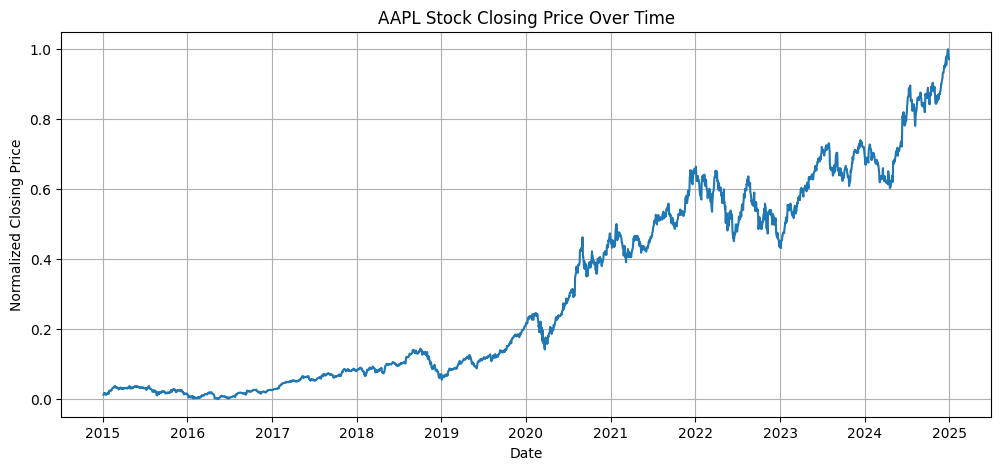

In [ ]:
# ---------------------------------------------------------------------
# 4️⃣ Exploratory Data Analysis (EDA)
# ---------------------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'])
plt.title(f"{ticker} Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Closing Price")
plt.grid(True)
plt.show()

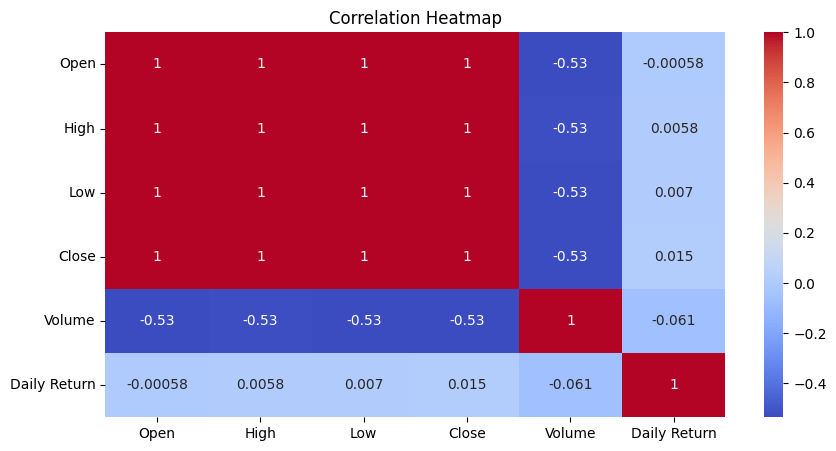

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['Open','High','Low','Close','Volume','Daily Return']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

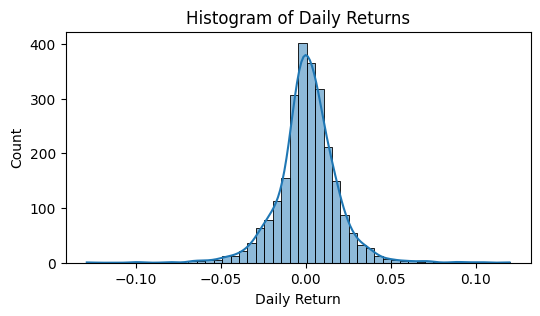

In [ ]:
plt.figure(figsize=(6,3))
sns.histplot(df['Daily Return'], bins=50, kde=True)
plt.title("Histogram of Daily Returns")
plt.show()

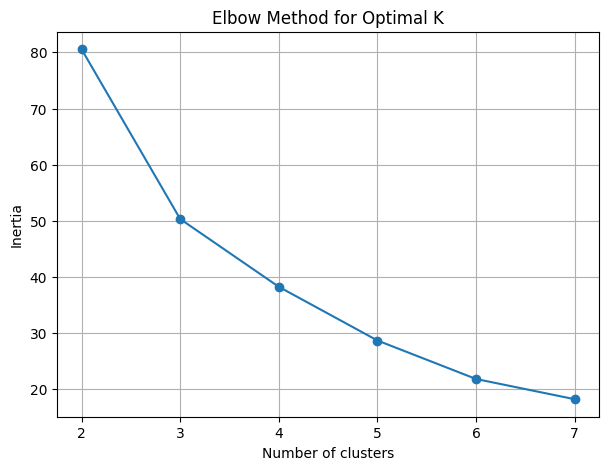

In [ ]:
# ---------------------------------------------------------------------
# 5️⃣ Data Mining – Pattern Recognition (Clustering)
# ---------------------------------------------------------------------
X = df[['Open','Close','Volume']].copy()

# Elbow Method to find optimal clusters
inertia = []
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(range(2,8), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


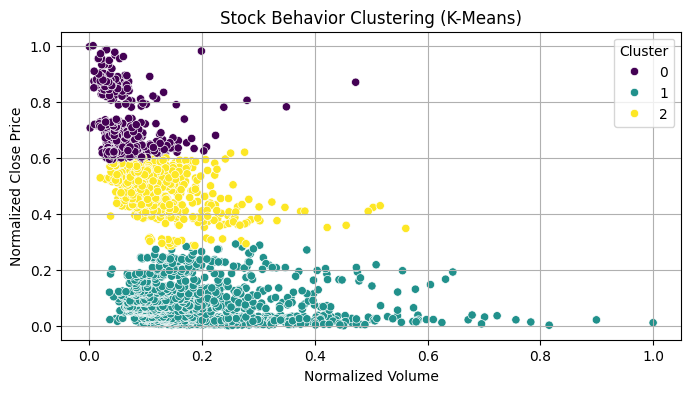

In [ ]:
# KMeans clustering (choose K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = pd.Series(kmeans.fit_predict(X), index=df.index)
# Scatter plot
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['Volume'], y=df['Close'], hue=df['Cluster'], palette='viridis')
plt.title("Stock Behavior Clustering (K-Means)")
plt.xlabel("Normalized Volume")
plt.ylabel("Normalized Close Price")
plt.grid(True)
plt.show()

In [ ]:
# ---------------------------------------------------------------------
# 6️⃣ Data Mining – Association Rules on Daily Returns
# ---------------------------------------------------------------------
df['Return_Label'] = pd.qcut(df['Daily Return'], 3, labels=['Low','Medium','High'])
one_hot = pd.get_dummies(df['Return_Label'])
rules_df = pd.DataFrame(one_hot)

frequent_items = apriori(rules_df, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
print("Top Association Rules:\n", rules[['antecedents','consequents','support','confidence','lift']].head())

Top Association Rules:
 Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


Linear Regression RMSE: 0.0027


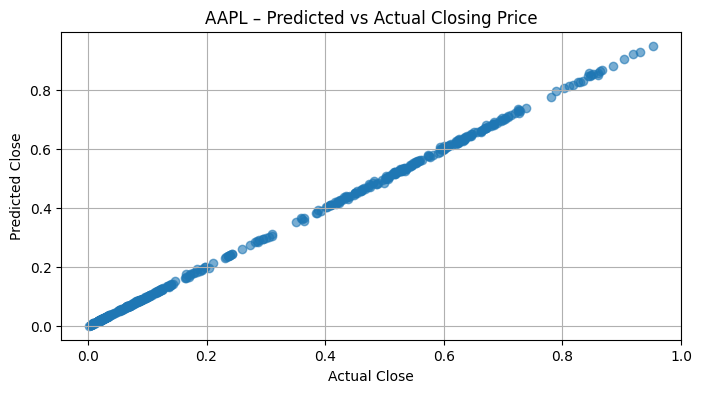

In [ ]:
# ---------------------------------------------------------------------
# 7️⃣ Predictive Modeling – Linear Regression
# ---------------------------------------------------------------------
df['Prev_Close'] = df['Close'].shift(1)
df.dropna(inplace=True)

X = df[['Open','High','Low','Volume','Prev_Close']]
y = df['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression RMSE: {rmse:.4f}")

plt.figure(figsize=(8,4))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Close")
plt.ylabel("Predicted Close")
plt.title(f"{ticker} – Predicted vs Actual Closing Price")
plt.grid(True)
plt.show()

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0210 - mae: 0.0886 - val_loss: 1.9789e-04 - val_mae: 0.0121
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1386e-04 - mae: 0.0078 - val_loss: 4.2898e-05 - val_mae: 0.0049
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3470e-05 - mae: 0.0046 - val_loss: 2.8993e-05 - val_mae: 0.0039
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0020e-05 - mae: 0.0039 - val_loss: 2.7125e-05 - val_mae: 0.0038
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0340e-05 - mae: 0.0037 - val_loss: 2.3972e-05 - val_mae: 0.0037
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3767e-05 - mae: 0.0034 - val_loss: 3.6118e-05 - val_mae: 0.0042
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6268e-05 - mae: 0.0041 - val_loss: 2.2065e-05 - val_mae: 0.0033
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2862e-05 - mae: 0.0031 - val_loss: 2.2211e-05 - val_mae: 0.0033
Epoch 9/25
5

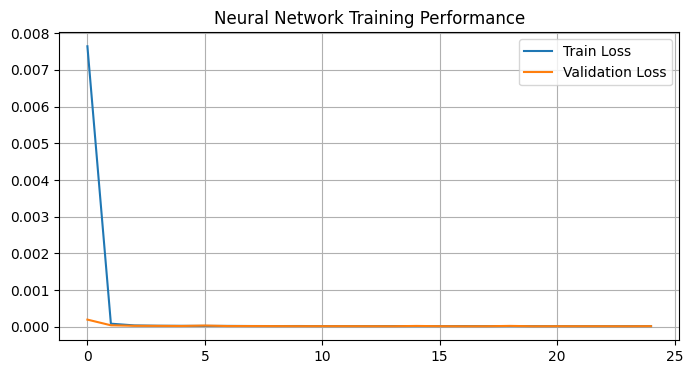

In [ ]:
# ---------------------------------------------------------------------
# 8️⃣ Predictive Modeling – Neural Network
# ---------------------------------------------------------------------
from keras.models import Sequential
model = Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=25, verbose=1)
# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Neural Network Test MAE: {test_mae:.4f}")
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Neural Network Training Performance")
plt.grid(True)
plt.show()

In [ ]:
# ---------------------------------------------------------------------
# 9️⃣ Forecast Next 5 Days (iterative)
# ---------------------------------------------------------------------
# Prepare last row as numeric array
last_row = df.iloc[-1][['Open','High','Low','Volume','Close']].values.astype(np.float32).reshape(1,-1)

# Predict next 5 days
future_predictions = []

for _ in range(5):
    pred = model.predict(last_row, verbose=0)
    future_predictions.append(float(pred[0][0]))

    # Update last_row for next iteration: shift 'Close' to new predicted value
    last_row = np.array([[last_row[0,0], last_row[0,1], last_row[0,2], last_row[0,3], pred[0][0]]], dtype=np.float32)

print("Predicted next 5-day closing prices for", ticker, ":", future_predictions)


Predicted next 5-day closing prices for AAPL : [0.9672606587409973, 0.9675602912902832, 0.9675384163856506, 0.96753990650177, 0.9675398468971252]


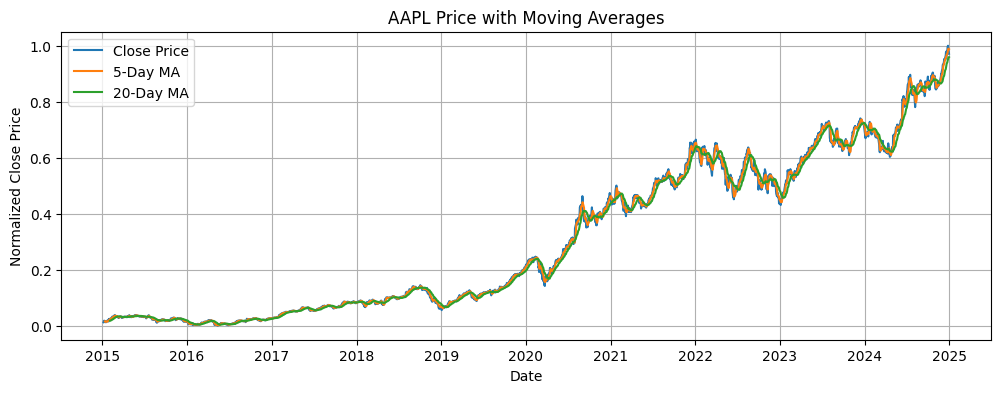

In [ ]:
# Add 5-day and 20-day moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA_5'], label='5-Day MA')
plt.plot(df['Date'], df['MA_20'], label='20-Day MA')
plt.title(f"{ticker} Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Normalized Close Price")
plt.legend()
plt.grid(True)
plt.show()


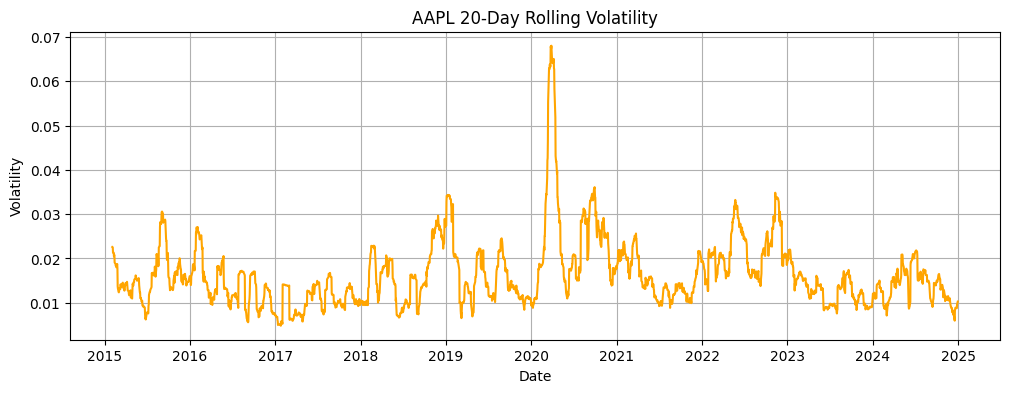

In [ ]:
df['Volatility'] = df['Daily Return'].rolling(window=20).std()

plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Volatility'], color='orange')
plt.title(f"{ticker} 20-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()


Cluster-wise average values:
              Open     Close    Volume
Cluster                              
0        0.717421  0.715635  0.060367
1        0.079612  0.079201  0.196418
2        0.482474  0.481088  0.121006


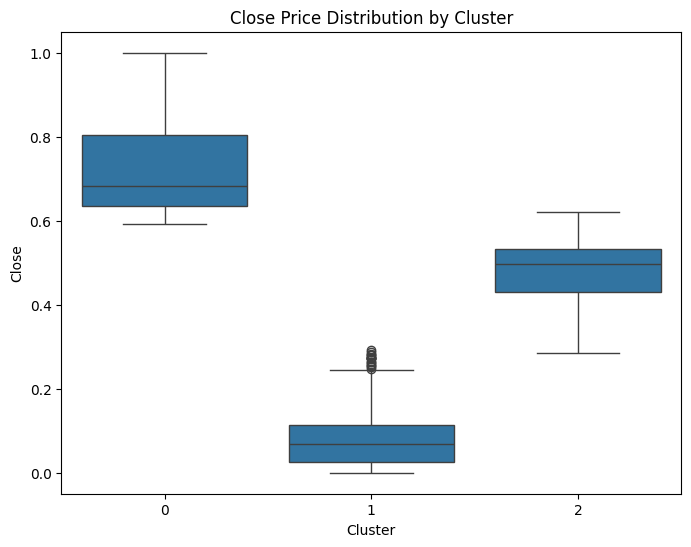

In [ ]:
cluster_summary = df.groupby('Cluster')[['Open','Close','Volume']].mean()
print("Cluster-wise average values:\n", cluster_summary)

# Plot cluster-wise distribution
plt.figure(figsize=(8,6))
sns.boxplot(x='Cluster', y='Close', data=df)
plt.title("Close Price Distribution by Cluster")
plt.show()


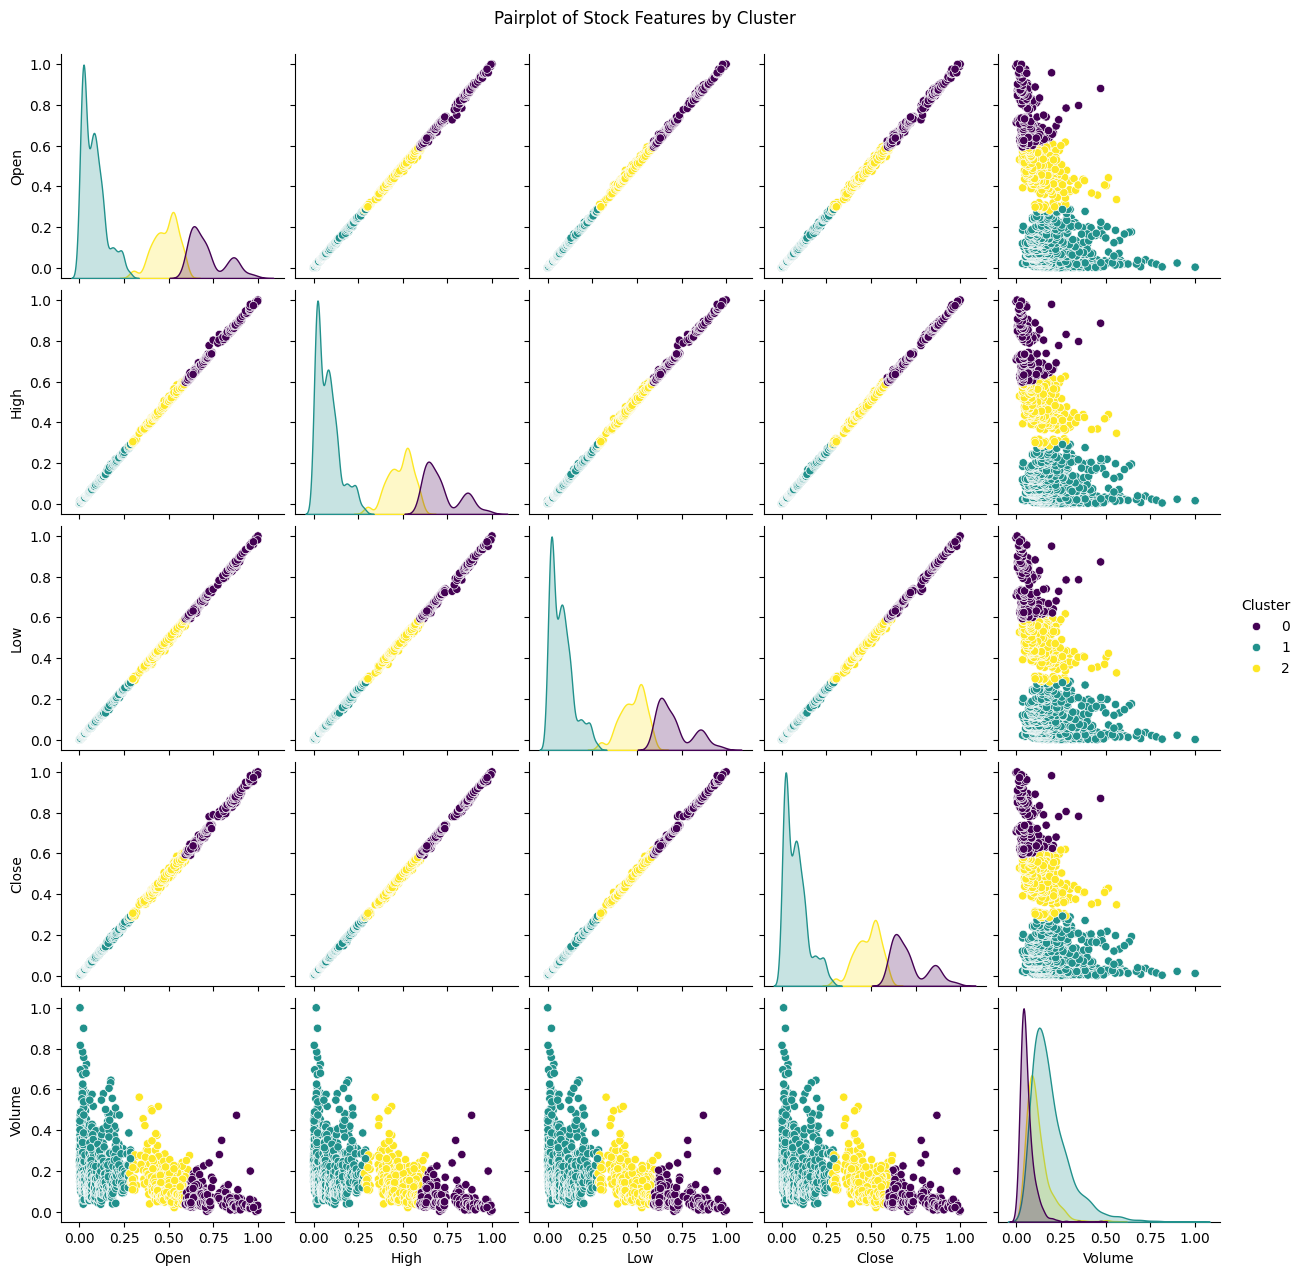

In [ ]:
sns.pairplot(df[['Open','High','Low','Close','Volume','Cluster']], hue='Cluster', palette='viridis')
plt.suptitle("Pairplot of Stock Features by Cluster", y=1.02)
plt.show()


Linear Regression Feature Coefficients:
       Feature  Coefficient
0        Open    -0.557420
1        High     0.801365
2         Low     0.801936
3      Volume    -0.000053
4  Prev_Close    -0.045105


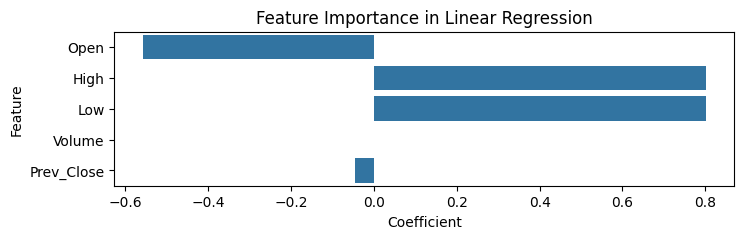

In [ ]:
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lr_model.coef_})
print("Linear Regression Feature Coefficients:\n", coef_df)

plt.figure(figsize=(8,2))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title("Feature Importance in Linear Regression")
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


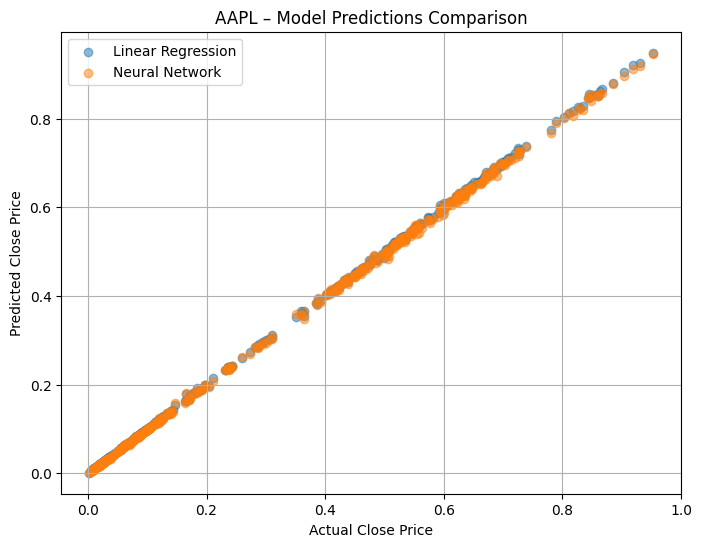

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Linear Regression')
nn_pred = model.predict(X_test)
plt.scatter(y_test, nn_pred, alpha=0.5, label='Neural Network')
plt.xlabel("Actual Close Price")
plt.ylabel("Predicted Close Price")
plt.title(f"{ticker} – Model Predictions Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib
import os

if not os.path.exists("models"):
    os.makedirs("models")

# Linear Regression
joblib.dump(lr_model, "models/linear_regression.joblib")
print("✔ Saved linear_regression.joblib")

# ANN Model
model.save("models/ann_model.h5")
print("✔ Saved ann_model.h5")


# Scaler
joblib.dump(scaler, "models/minmax_scaler.joblib")
print("✔ Saved minmax_scaler.joblib")


✔ Saved linear_regression.joblib
✔ Saved ann_model.h5
✔ Saved minmax_scaler.joblib


In [ ]:
who_ls = [var for var in dir() if not var.startswith("_")]
who_ls


['In',
 'KMeans',
 'LinearRegression',
 'LogisticRegression',
 'MinMaxScaler',
 'Out',
 'Sequential',
 'X',
 'X_test',
 'X_train',
 'accuracy_score',
 'apriori',
 'association_rules',
 'classification_report',
 'cluster_summary',
 'coef_df',
 'confusion_matrix',
 'df',
 'exit',
 'frequent_items',
 'future_predictions',
 'get_ipython',
 'history',
 'inertia',
 'joblib',
 'k',
 'keras',
 'km',
 'kmeans',
 'last_row',
 'layers',
 'lr_model',
 'mean_squared_error',
 'model',
 'nn_pred',
 'np',
 'one_hot',
 'os',
 'pd',
 'plt',
 'pred',
 'quit',
 'rmse',
 'rules',
 'rules_df',
 'scaler',
 'sns',
 'test_loss',
 'test_mae',
 'tf',
 'ticker',
 'train_test_split',
 'warnings',
 'y',
 'y_pred',
 'y_test',
 'y_train',
 'yf']